# Multi class logistic regression

In [1]:
import tensorflow as tf # need to import the right package
import numpy as np 


Here we will build a simple logistic regression model to classify mnist data set

Task: **classify the hadwritten digit label $\in \{1, 2, \cdots, 9 \}$ using pixel from the digit image.**

This is classification(discrete label output) problem and multi class logistic regression can be used here

Check   [Yann LeCun](http://yann.lecun.com/),      http://yann.lecun.com/exdb/mnist/  website for details about mnist dataset etc.



In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Verifying if everthing looks good

In [4]:
print('{} training example with shape {}'.format(mnist.train.num_examples, mnist.train.images[0].shape))
print('{} test example with shape {}'.format(mnist.test.num_examples, mnist.test.images[0].shape))
mnist.train.images.shape

55000 training example with shape (784,)
10000 test example with shape (784,)


(55000, 784)

Dataset contains 55000 training and 10000 test example for handwritten digits in vectorized form(take pixel along rows and stack them in a column vector).

Images are 28X28 gray scale. After vectrorization we have 784 dimentional vector

In [ ]:
28*28 == 784

## Sanity check

In [5]:

NUM_CLASSES = 10
X_DIM = 28
Y_DIM = 28
import numpy as np
unique_label = np.unique(np.argmax(mnist.train.labels, 1))
print(unique_label)
assert NUM_CLASSES == len(unique_label), 'number of label does not match'
assert X_DIM*Y_DIM == mnist.train.images[0].size, 'total pixel does not match'

[0 1 2 3 4 5 6 7 8 9]


## Viewing some of them

In [6]:
# magic command so that images are inline in notebook
%matplotlib inline 
import matplotlib.pyplot as plt # visualization package in python

[ 2732 43567 42613 52416 45891 21243 30403 32103 41993 20757 46884 14935
 15430 48600 39512 52620]


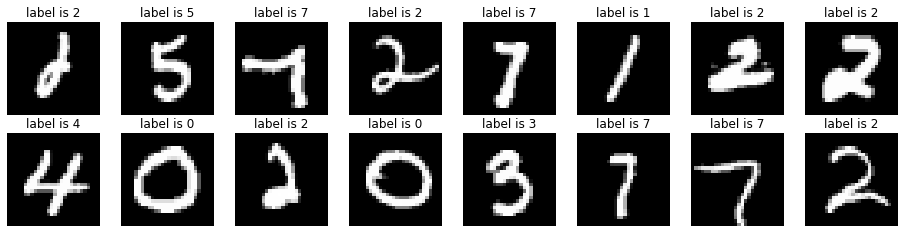

In [7]:
np.random.seed(0) # to make sure we have deterministic results on each iteration
NUM_FIG_DISP = 16
nrow = NUM_FIG_DISP//2
ncol = NUM_FIG_DISP//2
rand_ind = np.random.randint(mnist.train.num_examples, size=NUM_FIG_DISP)
print(rand_ind)
plt.figure(1,figsize= (16, 16))
plt.gray()
for idx, image_index in enumerate(rand_ind):
    plt.subplot(nrow,ncol,idx +1)
    # Have to reshape to 28x28 for display
    plt.imshow(np.reshape(mnist.train.images[image_index], (X_DIM, Y_DIM)) )
    plt.title('label is {}'.format(np.argmax(mnist.train.labels[image_index])))  
    plt.axis('off')
plt.show()

### For each class $c \in \{1, 2, \cdots, K= 10   \}$ we need to compute

 probablity
 <font size = 6>
 $P(y = c|x) = \frac{\exp(w_{oc} + w_c^Tx)}{\sum_i^K \exp(w_{oi} + w_i^Tx) }$
 </font>
 
 
 Note the one can either add 1 to features or work with $D+1$ dimentional features or add class bias $w_{oc}$ term for each class explicility as done in above formula.
 
 We can keep each weight vector $[w_{c}]_{D \times 1}$ in $D\times K$ matrix $W$, 
 $$W = {\begin{bmatrix} w_1, w_2, \cdots, w_K \end{bmatrix}}_{D \times K}$$
 
 and class biases  in vector  $W_o = {\begin{bmatrix} w_{o1}\\ w_{02} \\ \vdots \\ w_{0K} \end{bmatrix}}_{K \times 1}$. $D$ is data dimension.
 
 
 Using matrix operation we can calculate each class probability for given example $x_{784 \times 1}$ by doing
 
 $softmax(W_o +  W^T x)$ where 
 
 $$W_o + W^Tx = \begin{bmatrix} w_{o1}\\ \vdots \\ w_{oK} \end{bmatrix} + \begin{bmatrix}  w_1^T\\ \vdots \\  w_K^T \end{bmatrix} x = \begin{bmatrix}w_{01} + w_1^Tx\\ \vdots \\ w_{0K} + w_K^Tx \end{bmatrix}$$
 
 Also, 
 <font size = 5>
 
 $$softmax(\begin{bmatrix} z_1 \\ z_2 \\ \vdots \\ z_K  \end{bmatrix}) = \begin{bmatrix} \frac{\exp(z_1)}{\sum_i^K \exp(z_i)} \\ \frac{\exp(z_2)}{\sum_i^K \exp(z_i)} \\ \vdots \\ \frac{\exp(z_K)}{\sum_i^K \exp(z_i)}  \end{bmatrix} $$ </font>
 
 By applying softmax, we will get the formula at the beginning of the cell.

In [8]:
PIXELS_PER_SAMPLE = X_DIM*Y_DIM

X =  tf.placeholder(tf.float32, [None, PIXELS_PER_SAMPLE])
Y = tf.placeholder(tf.float32, [None,10])

print(X.shape, Y.shape)



(?, 784) (?, 10)


In [10]:
with tf.variable_scope("multi_class_logistic_model", reuse=tf.AUTO_REUSE):
    W = tf.get_variable('Weight_matrix', initializer = tf.random_normal(shape = (X_DIM*Y_DIM, NUM_CLASSES)))    
    W_o= tf.get_variable('W0_matrix', initializer = tf.zeros([NUM_CLASSES, 1]))
    print(X.shape, W.shape, W_o.shape)
    # we have to do X traspose as examples are along the row and we need them along columns

    Y_pred = tf.matmul(tf.transpose(W), tf.transpose(X))  + W_o
    
print('shape of prediction vector is {}'.format(Y_pred.shape))

(?, 784) (784, 10) (10, 1)
shape of prediction vector is (10, ?)


# '?' in above shape represent free dimension so let transpose it again to keep free dimension first

In [11]:

Y_pred = tf.transpose(Y_pred)
print('shape of prediction vector is {}'.format(Y_pred.shape))

shape of prediction vector is (?, 10)


## Let's convert this score vector of 10 into probability vector using softmax

In [12]:
Y_pred_prob = tf.nn.softmax(Y_pred)
print('shape of prediction vector is {}'.format(Y_pred_prob.shape))

shape of prediction vector is (?, 10)


## Building a loss/cost/objective function to measure how good we are doing

We use cross entopy.

In [28]:
loss = -tf.math.reduce_sum(tf.linalg.tensor_diag_part(tf.matmul(Y, tf.transpose(tf.math.log(Y_pred_prob)))))

## Building an accuracy measure

In [14]:
max_val = tf.math.argmax(Y_pred_prob, axis = 1)
accuracy = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(max_val, tf.argmax(Y, axis = 1)), tf.float32))

In [15]:
accuracy.get_shape()

TensorShape([])

## Creating an optimizer

In [31]:
opt = tf.train.GradientDescentOptimizer(learning_rate = 0.1).minimize(loss)


## When we run above *opt*(optimizer node) node it calculates loss, gradient and updates the model weights

In [17]:
print(mnist.train.images[0].dtype)
print(mnist.train.labels[0].dtype)

float32
float64


In [18]:
BATCH_SIZE = 100
NUM_EPOCHS = 20

## Running the model

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for eidx in range(NUM_EPOCHS):
        epoch_acc, epoch_loss = [], []
        for bidx in range(mnist.train.num_examples// BATCH_SIZE):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            xs = xs.astype(np.float32)
            _, train_loss, train_acc= sess.run([opt, loss, accuracy], feed_dict = {X: xs, Y:ys})
            if (bidx+1)%100 == 0: # print result every 100 batch
                print('epoch {} training batch {} loss {} accu {}'.format(eidx +1 , bidx +1, train_loss, train_acc))
            epoch_acc.append(train_acc)
            epoch_loss.append(train_loss)
        print('##################################')
        val_acc, val_loss = sess.run([accuracy, loss],
            feed_dict= {X:mnist.test.images.astype(np.float32), Y: mnist.test.labels})
        print('epoch {} # test accuracy {} $ test loss {}'.format(eidx +1, val_acc, val_loss ))
        print('##################################') 
        # Let keep epoch level values for plotting
        train_losses.append(np.mean(epoch_loss))
        train_accuracies.append(np.mean(epoch_acc))
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
                

epoch 1 training batch 100 loss nan accu 0.07999999821186066
epoch 1 training batch 200 loss nan accu 0.07000000029802322
epoch 1 training batch 300 loss nan accu 0.12999999523162842
epoch 1 training batch 400 loss nan accu 0.12999999523162842
epoch 1 training batch 500 loss nan accu 0.10999999940395355
##################################
epoch 1 # test accuracy 0.09799999743700027 $ test loss nan
##################################
epoch 2 training batch 100 loss nan accu 0.07999999821186066
epoch 2 training batch 200 loss nan accu 0.03999999910593033
epoch 2 training batch 300 loss nan accu 0.07999999821186066
epoch 2 training batch 400 loss nan accu 0.05999999865889549
epoch 2 training batch 500 loss nan accu 0.029999999329447746
##################################
epoch 2 # test accuracy 0.09799999743700027 $ test loss nan
##################################
epoch 3 training batch 100 loss nan accu 0.07999999821186066
epoch 3 training batch 200 loss nan accu 0.07000000029802322
epoch 3

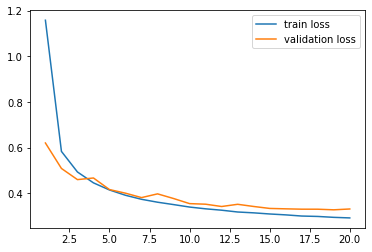

In [40]:
plt.plot(range(1, NUM_EPOCHS+1),  train_losses)
plt.plot(range(1, NUM_EPOCHS+1),  val_losses)
plt.legend(['train loss','validation loss'])
plt.show()

## Plot showing training and validation accuracies

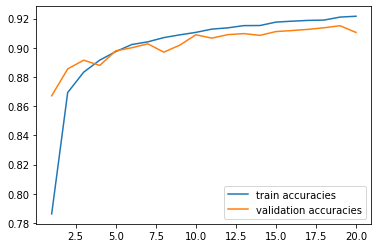

In [41]:
plt.plot(range(1, NUM_EPOCHS+1),  train_accuracies)
plt.plot(range(1, NUM_EPOCHS+1),  val_accuracies)
plt.legend(['train accuracies','validation accuracies'])
plt.show()